# Initial ROI Analysis for Analogy

This analysis runs an ROI analysis on the masks specified in the config files.

This analysis requires 10 GB at least to run

RUN ROI CROSS CLASSIFICATION AB -> CD

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == 'darwin':
    cfg = os.path.join("/Users", "njchiang", "CloudStation", "Grad",
                       "Research", "montilab-ucla", "analogy", "config", "project.json")
    plat = "osx"

elif sys.platform == "linux":
    import platform
    if platform.linux_distribution()[0] == "debian":
        cfg = os.path.join("/home", "njchiang", "data", "CloudStation", "Grad",
                           "Research", "montilab-ucla", "analogy", "config", "project.json")
        plat = "linux"
    else:
        cfg = os.path.join("/u", "project", "monti", "Analysis", "Analogy",
                           "code", "analogy", "config", "project.json")
        plat = "hoff"
else:
    cfg = os.path.join("D:\\", "CloudStation", "Grad",
                       "Research", "montilab-ucla", "analogy", "config", "project.json")
    plat = "win"

with open(cfg, "r") as f:
    projectSettings = json.load(f)

paths = projectSettings["filepaths"]["{}Paths".format(plat)]
sys.path.append(paths["github"])
sys.path.append(paths["code"])

In [3]:
from fmri.analogy_utils import analysisSettings, contrastSettings, order, \
    pu, pa, pv, compile_models, rsa, save_rois, load_rois, load_betas


Loading JSON config from D:\CloudStation\Grad\Research\montilab-ucla\analogy\config\analyses.json
Loading JSON config from D:\CloudStation\Grad\Research\montilab-ucla\analogy\config\contrasts.json
Loading label file from: D:\CloudStation\Grad\Research\montilab-ucla\analogy\labels\trialorder_rsa_absorted.csv


In [4]:
from fmri.analogy_rsa import \
downsample_rdms_df_by_factor, create_models, models_to_df, plotmodels,\
roi_rdm, run_rsa_dfs, subject_rdms, plot_results

In [5]:
masks_dict = analysisSettings["roi"]["masks"]

In [6]:
# b = "LSA"
# b = "pymvpa"
# b = "cope-LSS"
b = analysisSettings["roi"]["t"]
rois, labels = load_rois(b)
modelnames = ["mainrel", "subrel", 
              "rel", "humanratings", "numchar", 
              "w2vdiff", "concatword", 
              "rstpostprob9", "rstpostprob79", 
#               ["rel", "rstpostprob9"], 
#               ["rel", "w2vdiff"], 
#               ["rstpostprob9", "concatword"],
#               ["rstpostprob9", "w2vdiff"]
             ]

# modelnames = ["mainrel", "subrel", "rel", "humanratings"]

raw_models_df = pu.load_labels(os.path.join(paths["code"], "labels", "raw_models.csv"))


Loading sub-01 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\rois\sub-01_cope-LSS_labels.csv
Loading sub-02 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\rois\sub-02_cope-LSS_labels.csv
Loading sub-03 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-03\rois\sub-03_cope-LSS_labels.csv
Loading sub-04 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-04\rois\sub-04_cope-LSS_labels.csv
Loading sub-05 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-05\rois\sub-05_cope-LSS_labels.csv
Loading sub-06 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-06\rois\sub-06_cope-LSS_labels.csv
Loading sub-07 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-07\rois\sub-07_cope-LSS_labels.csv
Loading sub-08 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\rois\sub-08_cope-LSS_labels.csv
Loading sub-09 betas
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\rois\sub-09_cop

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import \
SelectFromModel, SelectPercentile, SelectKBest, f_classif, VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

cv = LeaveOneGroupOut()
pipe = Pipeline(steps=[# ("variance_threshold", VarianceThreshold()),
                       ("scaling", StandardScaler()),
#                        ("pca", PCA(150)),
#                        ("feature_select", SelectPercentile(f_classif, percentile=50)),
#                        ("feature_select", SelectKBest(f_classif, k=100)),
                       ("svm", LinearSVC(C=1))
#                        ("knn", KNeighborsClassifier())
#                        ("plr", LogisticRegression(C=0.05, penalty="l1", tol=0.01))
])

In [8]:
# Can we predict main label based on BART output?
for l in modelnames:
    print("{} classifiability | {}".format(l, cross_val_score(LinearSVC(), 
                    raw_models_df[[c for c in raw_models_df.columns if l in c]][::2], 
                    raw_models_df[::2]["MainCond"]).mean()))

mainrel classifiability | 1.0
subrel classifiability | 0.3333333333333333
rel classifiability | 1.0
humanratings classifiability | 1.0
numchar classifiability | 0.47222222222222215
w2vdiff classifiability | 0.36111111111111116
concatword classifiability | 0.6180555555555556
rstpostprob9 classifiability | 0.40972222222222227
rstpostprob79 classifiability | 0.5347222222222222


In [83]:
# overfit
# one-way classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        label = label[label.Probe == 0]
        roi = rois[s][m][label.index]
#         results[m].append(pipe.fit(roi[(label.CD == 1) & (label.Match == "0")], 
#                                    label[(label.CD == 1) & (label.Match == "0")].MainRel)
#                       .score(roi[(label.CD == 1) & (label.Match == "0")], 
#                              label[(label.CD == 1) & (label.Match == "0")].MainRel))
        results[m].append(pipe.fit(roi[label.AB == 1], label[label.AB == 1].MainRel)
                      .score(roi[label.AB == 1], label[label.AB == 1].MainRel))

pd.DataFrame(results).mean()

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

ba10      1.0
ba44      1.0
ba45      1.0
ba46      1.0
ba47      1.0
lpstg     1.0
laitg     1.0
lpmtg     1.0
ltp       1.0
ltomtg    1.0
lastg     1.0
lips      1.0
lag       1.0
v1        1.0
csf       1.0
dtype: float64

In [84]:
print(pipe.score(roi[(label.CD == 1) & (label.Match == "0")], label[(label.CD == 1) & (label.Match == "0")].MainRel))
print(pipe.score(roi[(label.CD == 1) & (label.Match == "1")], label[(label.CD == 1) & (label.Match == "1")].MainRel))
print(pipe.score(roi[(label.CD == 1)], label[(label.CD == 1)].MainRel))

0.2708333333333333
0.4166666666666667
0.34375


Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

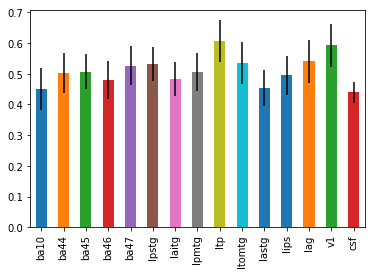

In [11]:
# one-way classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        label = label[label.Probe == 0]
#         selector = label[label.Probe == 0]
        roi = rois[s][m][label.index]
#         results[m].append(cross_val_score(pipe, roi, selector.MainRel, cv=cv, groups=selector.TrialType).mean())
        results[m].append(pipe.fit(roi[label.AB == 1], label[label.AB == 1].MainRel)
                          .score(roi[(label.CD == 1) & (label.Match == "1")], 
                                 label[(label.CD == 1) & (label.Match == "1")].MainRel))
    
# pd.DataFrame(results).to_csv(
#     os.path.join(paths["root"], "analysis", "group", "multivariate", 
#                  "roi_{}_standardize-svm_AB2CDMatch-MainRel.csv".format(b)), index=False)



res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_AB2CDMatch-MainRel.csv".format(b)), index=False)
ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())


Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

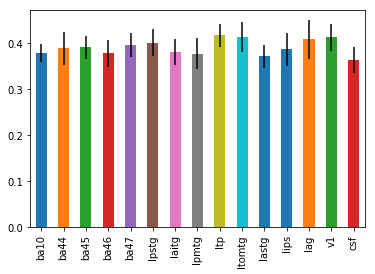

In [13]:
# one-way classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        label = label[label.Probe == 0]
#         selector = label[label.Probe == 0]
        roi = rois[s][m][label.index]
#         results[m].append(cross_val_score(pipe, roi, selector.MainRel, cv=cv, groups=selector.TrialType).mean())
        results[m].append(pipe.fit(roi[label.AB == 1], label[label.AB == 1].MainRel)
                          .score(roi[(label.CD == 1)], 
                                 label[(label.CD == 1)].MainRel))

res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

    
stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_AB2CD-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())
        # ab2cd
#         results[m].append(cross_val_score(pipe, roi, selector.MainRel, cv=cv, groups=selector.TrialType)[1])

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

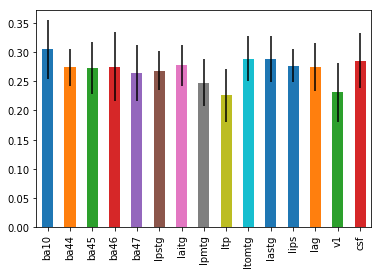

In [15]:
# one-way classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        label = label[label.Probe == 0]
#         selector = label[label.Probe == 0]
        roi = rois[s][m][label.index]
#         results[m].append(cross_val_score(pipe, roi, selector.MainRel, cv=cv, groups=selector.TrialType).mean())
        results[m].append(pipe.fit(roi[label.AB == 1], label[label.AB == 1].MainRel)
                          .score(roi[(label.CD == 1) & (label.Match == "0")], 
                                 label[(label.CD == 1) & (label.Match == "0")].MainRel))
    
res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)
    
stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_AB2CDNoMatch-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())
        # ab2cd
#         results[m].append(cross_val_score(pipe, roi, selector.MainRel, cv=cv, groups=selector.TrialType)[1])

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

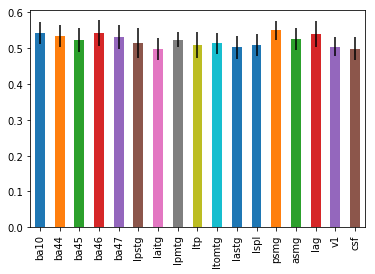

In [8]:
# Match classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        selector = label[label.Probe == 0]
        roi = rois[s][m][selector.index]
        # CD Match vs NoMatch
        results[m].append(
            cross_val_score(pipe, roi[selector.CD == 1], 
                            selector[selector.CD == 1].Match, 
                            cv=cv, 
                            groups=selector[selector.CD == 1].chunks).mean())

res = pd.DataFrame(results)
res["chance"] = 0.5
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_CD-Match_newROI.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

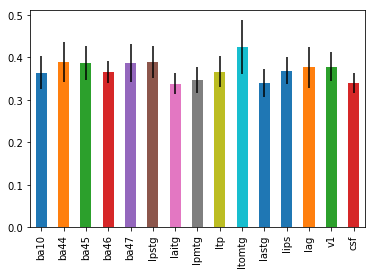

In [17]:
# AB MainRel classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        selector = label[label.Probe == 0]
        roi = rois[s][m][selector.index]
        # CD Match vs NoMatch
        results[m].append(
            cross_val_score(pipe, roi[selector.AB == 1], 
                            selector[selector.AB == 1].MainRel, 
                            cv=cv, 
                            groups=selector[selector.AB == 1].chunks).mean())

res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_AB-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

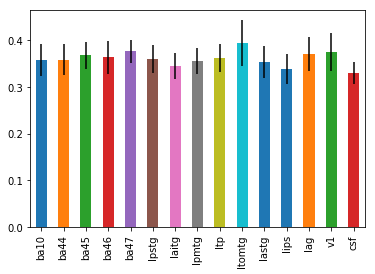

In [18]:
# CD MainRel classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        selector = label[label.Probe == 0]
        roi = rois[s][m][selector.index]
        # CD Match vs NoMatch
        results[m].append(
            cross_val_score(pipe, roi[selector.CD == 1], 
                            selector[selector.CD == 1].MainRel, 
                            cv=cv, 
                            groups=selector[selector.CD == 1].chunks).mean())

res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_CD-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

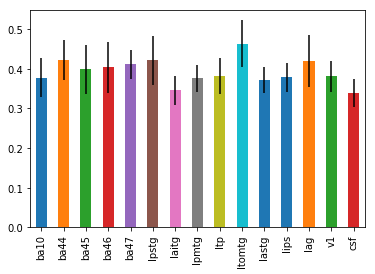

In [19]:
# CDMatch MainRel classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        selector = label[label.Probe == 0]
        roi = rois[s][m][selector.index]
        # CD Match vs NoMatch
        results[m].append(
            cross_val_score(pipe, roi[(selector.CD == 1) & (selector.Match == "1")], 
                            selector[(selector.CD == 1) & (selector.Match == "1")].MainRel, 
                            cv=cv, 
                            groups=selector[(selector.CD == 1) & (selector.Match == "1")].chunks).mean())

res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_CDMatch-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())

Processing sub-01: ba10
Processing sub-02: ba10
Processing sub-03: ba10
Processing sub-04: ba10
Processing sub-05: ba10
Processing sub-06: ba10
Processing sub-07: ba10
Processing sub-08: ba10
Processing sub-09: ba10
Processing sub-10: ba10
Processing sub-11: ba10
Processing sub-12: ba10
Processing sub-13: ba10
Processing sub-14: ba10
Processing sub-15: ba10
Processing sub-16: ba10
Processing sub-01: ba44
Processing sub-02: ba44
Processing sub-03: ba44
Processing sub-04: ba44
Processing sub-05: ba44
Processing sub-06: ba44
Processing sub-07: ba44
Processing sub-08: ba44
Processing sub-09: ba44
Processing sub-10: ba44
Processing sub-11: ba44
Processing sub-12: ba44
Processing sub-13: ba44
Processing sub-14: ba44
Processing sub-15: ba44
Processing sub-16: ba44
Processing sub-01: ba45
Processing sub-02: ba45
Processing sub-03: ba45
Processing sub-04: ba45
Processing sub-05: ba45
Processing sub-06: ba45
Processing sub-07: ba45
Processing sub-08: ba45
Processing sub-09: ba45
Processing sub-1

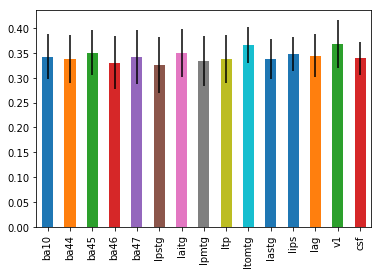

In [20]:
# CDNoMatch MainRel classification
results = {}
results["subjects"] = [s for s in projectSettings["subjects"]]
for m in masks_dict:
    results[m] = []
    for s in projectSettings["subjects"]:
        print("Processing {}: {}".format(s, m))
        label = labels[s]
        selector = label[label.Probe == 0]
        roi = rois[s][m][selector.index]
        # CD Match vs NoMatch
        results[m].append(
            cross_val_score(pipe, roi[(selector.CD == 1) & (selector.Match == "0")], 
                            selector[(selector.CD == 1) & (selector.Match == "0")].MainRel, 
                            cv=cv, 
                            groups=selector[(selector.CD == 1) & (selector.Match == "0")].chunks).mean())

res = pd.DataFrame(results)
res["chance"] = 1./3.
tvalues, pvalues = [], []
for m in masks_dict:
    t = wilcoxon(res[m], res["chance"])
    tvalues.append(t.statistic)
    pvalues.append(t.pvalue)

stats_df = pd.concat(
    [pd.DataFrame({"subjects": ["mean", "std", "score", "p", "corrp"]}), 
     pd.DataFrame(np.vstack([res.drop("chance", axis=1).mean().values, 
                             res.drop("chance", axis=1).std().values, 
                             tvalues, pvalues, 
                             multipletests(pvalues, method="bonferroni")[1]]), columns=masks_dict.keys())], 
    axis=1)
pd.DataFrame(results).append(stats_df, ignore_index=True).to_csv(
    os.path.join(paths["root"], "analysis", "group", "multivariate", 
                 "roi_{}_standardize-svm_CDNoMatch-MainRel.csv".format(b)), index=False)

ax = res.drop("chance", axis=1).mean().plot(kind="bar",
                yerr=res.drop("chance", axis=1).std())